In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm




CWD = Path.cwd()

RESULTS_DIR = CWD / "models_without_data" 
#RESULTS_DIR = CWD / "models_without_labels" 

# get the results from the plot_Dir
results = sorted(list(RESULTS_DIR.glob("eval*.pkl")))
import pickle 

def read_pickle(pickle_file):
    with open(pickle_file, 'rb') as f:
        return pickle.load(f)
results



[PosixPath('/n/home04/rrinberg/code/data_to_concept_unlearning/notebooks/models_without_data/evals_results__20250311_095734.pkl')]

In [35]:
res = read_pickle(results[0])

In [36]:
from torch.utils.data import DataLoader, Subset

BATCH_SIZE = 64  # Increase batch size for better training
NUM_WORKERS = 4
DATA_DIR = Path("/n/home04/rrinberg/data_dir/data_to_concept/")



# ========================
# 2. DATA LOADING (WITH STRONG AUGMENTATION)
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=False, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=False, target_type="attr")

train_labels = train_dataset.attr
val_labels = val_dataset.attr

    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']


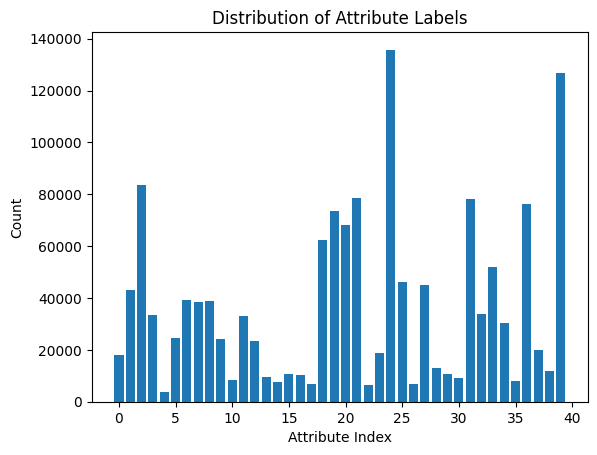

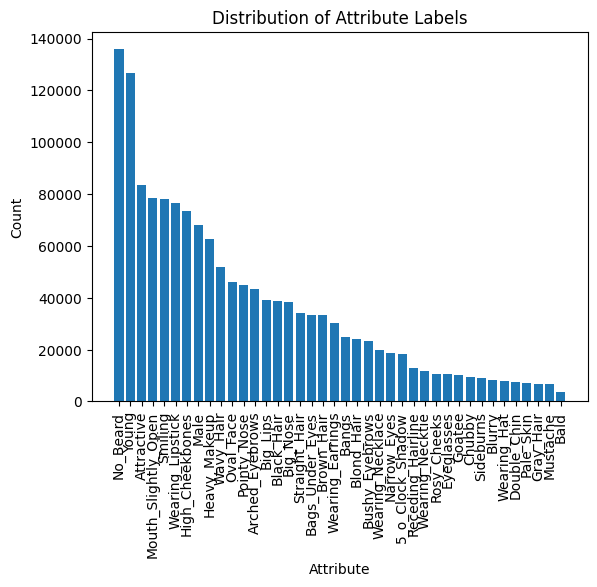

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


In [37]:

# 1 identify labels of attributes
#attribute_labels = 
print(train_dataset.attr_names)
# print histogram of labels
import matplotlib.pyplot as plt

import numpy as np
subset_targets = train_labels
counts = np.sum(subset_targets.numpy(), axis=0)
counts
# plot bar chart of counts
plt.bar(range(len(counts)), counts)
plt.xlabel("Attribute Index")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.show()


attribute_names = train_dataset.attr_names
# remove empty attributes
attribute_names = [name for name in attribute_names if name != '']

attribute_to_count = {train_dataset.attr_names[i] : counts[i] for i in range(len(counts))}
# Sort attributes by count

#sorted_attributes = [attribute_names[i] for i in sort_attribute_indices]

sorted_attributes = sorted(attribute_to_count.items(), key=lambda x: x[1], reverse=True)

# Print sorted attributes
#for attr, count in sorted_attributes:
#    print(f"{attr}: \t\t {count}")
# plot sorted attributes with counts, with text annotainos
x_axis = [attr for attr, count in sorted_attributes]
y_axis = [count for attr, count in sorted_attributes]
plt.bar(x_axis, y_axis)
plt.xlabel("Attribute")
plt.ylabel("Count")
plt.title("Distribution of Attribute Labels")
plt.xticks(rotation=90)
plt.show()



for i, attr_i in enumerate(attribute_names):
    print(i, attr_i)

## correlation of data

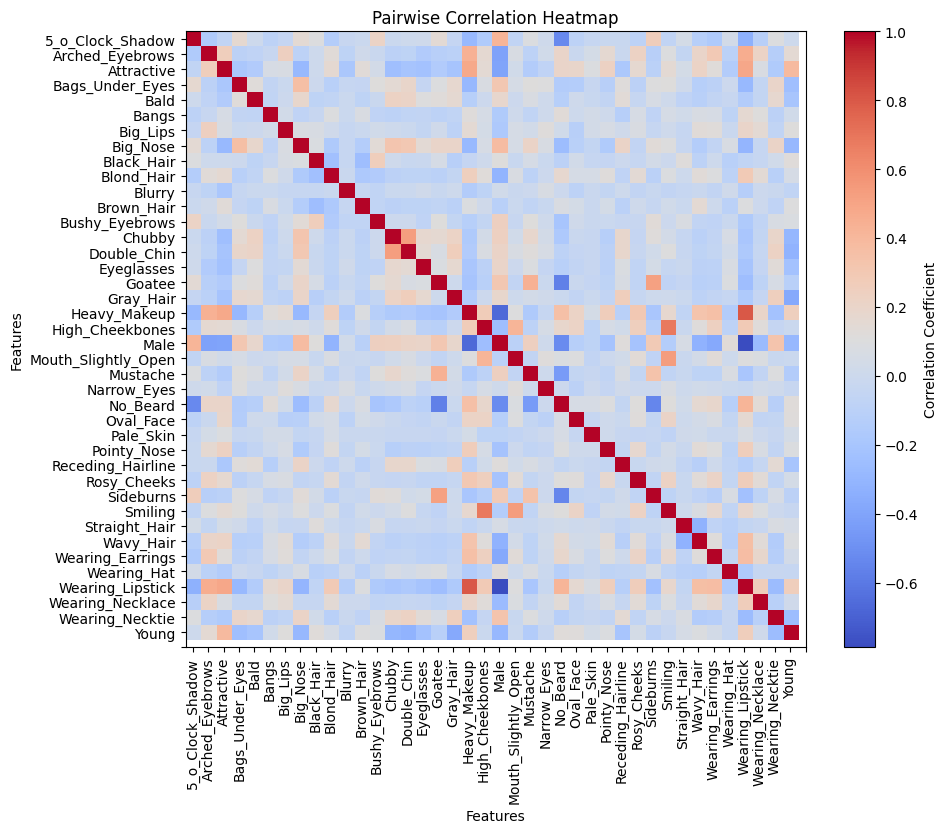

In [38]:
subset_targets_np = subset_targets.numpy()

correlation_matrix = np.corrcoef(subset_targets_np, rowvar=False)
correlation_matrix.shape


import matplotlib.pyplot as plt
attr_names = train_dataset.attr_names

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Correlation Coefficient")

# Set x and y ticks
plt.xticks(ticks=range(len(attr_names)), labels=attr_names, rotation=90)
plt.yticks(ticks=range(len(attr_names)), labels=attr_names)

plt.title("Pairwise Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

In [39]:
average_correlation = np.mean(correlation_matrix, axis=1)
attribute_to_correlation = {train_dataset.attr_names[i] : correlation_matrix[i] for i in range(len(correlation_matrix))}
# Sort attributes by average correlation
sorted_attributes = sorted(attribute_to_correlation.items(), key=lambda x: np.mean(x[1]), reverse=True)
# Print sorted attributes
for attr, correlation in sorted_attributes:
    print(f"{attr}: \t\t {np.mean(correlation):.4f}")

Smiling: 		 0.0922
High_Cheekbones: 		 0.0876
Mouth_Slightly_Open: 		 0.0688
Rosy_Cheeks: 		 0.0649
Heavy_Makeup: 		 0.0610
Arched_Eyebrows: 		 0.0598
Wearing_Lipstick: 		 0.0555
Wearing_Earrings: 		 0.0549
Big_Lips: 		 0.0544
Double_Chin: 		 0.0529
Big_Nose: 		 0.0521
Chubby: 		 0.0496
Wearing_Necklace: 		 0.0466
Attractive: 		 0.0418
Narrow_Eyes: 		 0.0376
Oval_Face: 		 0.0354
Pointy_Nose: 		 0.0354
Bags_Under_Eyes: 		 0.0346
Wavy_Hair: 		 0.0344
Mustache: 		 0.0330
Receding_Hairline: 		 0.0326
Bushy_Eyebrows: 		 0.0307
Bald: 		 0.0305
Wearing_Necktie: 		 0.0292
Goatee: 		 0.0270
Gray_Hair: 		 0.0253
Blond_Hair: 		 0.0252
Sideburns: 		 0.0225
Bangs: 		 0.0207
Black_Hair: 		 0.0177
Pale_Skin: 		 0.0154
Straight_Hair: 		 0.0089
Eyeglasses: 		 0.0071
Brown_Hair: 		 0.0032
5_o_Clock_Shadow: 		 0.0021
Young: 		 -0.0009
No_Beard: 		 -0.0043
Wearing_Hat: 		 -0.0077
Blurry: 		 -0.0090
Male: 		 -0.0231


# Counter Factual modelling results

In [40]:
len(attribute_names)

40

In [41]:
attribute_names

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

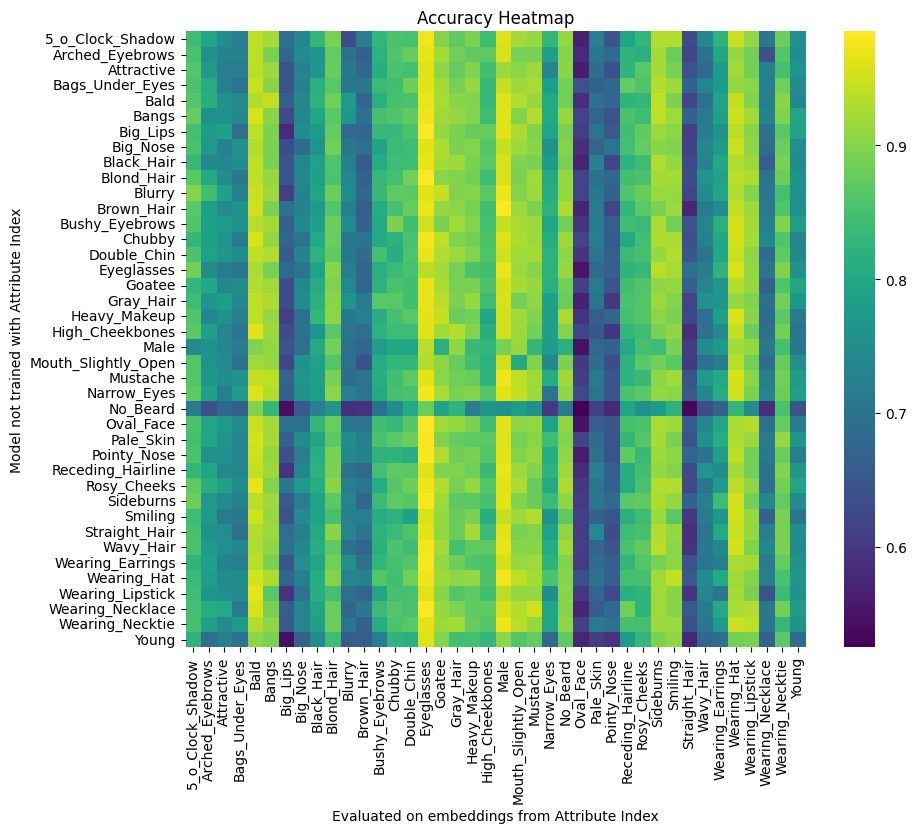

In [42]:


# Assuming your dictionary is named 'results'
size = 40  # Since it's a 40x40 matrix

# Initialize a 40x40 matrix with NaNs
heatmap_data = np.full((size, size), np.nan)

# Fill in the values from the dictionary
for (i, j), acc in res.items():
    heatmap_data[i, j] = acc

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)

plt.xlabel("Evaluated on embeddings from Attribute Index")
plt.ylabel("Model not trained with Attribute Index")

# label the axes with attribute names
plt.xticks(ticks=np.arange(size) + 0.5, labels=attribute_names, rotation=90)
plt.yticks(ticks=np.arange(size) + 0.5, labels=attribute_names, rotation=0)
plt.title("Accuracy Heatmap")

plt.show()

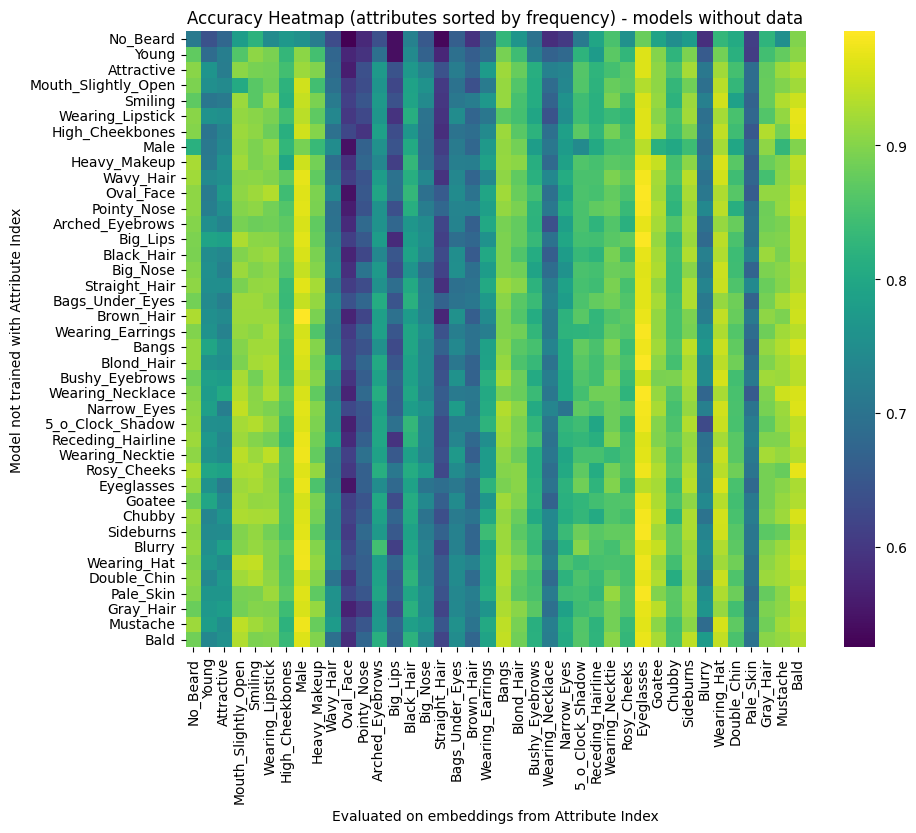

In [43]:

counts = np.sum(train_labels.numpy(), axis=0)
sort_attribute_indices = np.argsort(counts)[::-1]



# Assuming your dictionary is named 'results'
size = 40  # Since it's a 40x40 matrix

# Initialize a 40x40 matrix with NaNs
heatmap_data = np.full((size, size), np.nan)

# Fill in the values from the dictionary
for (i, j), acc in res.items():
    heatmap_data[i, j] = acc

heatmap_data = heatmap_data[sort_attribute_indices, :][:, sort_attribute_indices]


# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)

plt.xlabel("Evaluated on embeddings from Attribute Index")
plt.ylabel("Model not trained with Attribute Index")

# label the axes with attribute names
attr_names_sorted = [attribute_names[i] for i in sort_attribute_indices]    
plt.xticks(ticks=np.arange(size) + 0.5, labels=attr_names_sorted, rotation=90)
plt.yticks(ticks=np.arange(size) + 0.5, labels=attr_names_sorted, rotation=0)
plt.title(f"Accuracy Heatmap (attributes sorted by frequency) - {RESULTS_DIR.stem.replace('_', ' ')}")

plt.show()
